Author: Selim Yahia-Messaoud (1965129)

A short written report provides more explanations for the experiments conducted in this notebook.

#DLAI Project : Stock price prediction

We start by importing the necessary libraries.

In [ ]:
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential, Model
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

The data used for this study is the daily price of Alphabet stock (GOOG) from January 1, 2015 to June 14, 2021

In [ ]:
df=pd.read_csv("GOOG.csv")
print("Number of rows and columns:", df.shape)
df.head(5)
df.dropna(inplace=True)

Number of rows and columns: (1623, 7)


We define the lenght of the input sequences and perform the train/validation/test split.

In [ ]:
len_sequence=10
len_train=int(0.7*df.shape[0])
len_val=int(0.15*df.shape[0])
len_test=int(0.15*df.shape[0])

In [ ]:
training_set = df.iloc[:len_train, 1:2].values
validation_set = df.iloc[len_train:len_train+len_val, 1:2].values
test_set = df.iloc[len_train+len_val:, 1:2].values

Feature scaling helps the models to converge faster, so we fit a scaler on the train set and apply it to all the data.

In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set = sc.fit_transform(training_set)
validation_set = sc.transform(validation_set)
test_set = sc.transform(test_set)

The final processing step is to gather the time series into sub-sequences that will be fed to the different models.

In [ ]:
# Splitting the training set into sub sequences
X_train = []
y_train = []
for i in range(len_sequence, len_train):
    X_train.append(training_set[i-len_sequence:i, 0])
    y_train.append(training_set[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [ ]:
# Splitting the validation set into sub sequences
X_validation = []
y_validation = []
for i in range(len_sequence,len_val):
    X_validation.append(validation_set[i-len_sequence:i, 0])
    y_validation.append(validation_set[i, 0])
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

In [ ]:
# Splitting the test set into sub sequences
X_test = []
y_test = []
for i in range(len_sequence, test_set.shape[0]):
    X_test.append(test_set[i-len_sequence:i, 0])
    y_test.append(test_set[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#LSTM

We first build the lstm model.

In [ ]:
lstm = Sequential()
lstm.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
lstm.add(LSTM(units = 50))
# Adding the output layer
lstm.add(Dense(units = 1))

Then we fit it to the training data using adam optimizer. The model is relatively small so we can afford reducing the learning rate and increasing the number of epochs and batch size.

In [ ]:
# Compiling the model
lstm.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mean_squared_error')

# Fitting the RNN to the Training set
lstm.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs = 1000, batch_size = 128)

Epoch 1/1000
9/9 [==============================] - 23s 127ms/step - loss: 0.3012 - val_loss: 0.9107
Epoch 2/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.2438 - val_loss: 0.7564
Epoch 3/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1950 - val_loss: 0.6117
Epoch 4/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1551 - val_loss: 0.4747
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1157 - val_loss: 0.3473
Epoch 6/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0802 - val_loss: 0.2329
Epoch 7/1000
9/9 [==============================] - 0s 9ms/step - loss: 0.0466 - val_loss: 0.1389
Epoch 8/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0243 - val_loss: 0.0708
Epoch 9/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0309
Epoch 10/1000
9/9 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0141
Epoch 11/1000
9

Then, we evaluate the performance of the model on the test set.

In [ ]:
lstm.evaluate(X_test,y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.0086


0.008614549413323402

Finally, we build a plot to observe visually the performance of the model. The different set are separated by vertical lines.

In [ ]:
dataset_total=np.concatenate((X_train, X_validation, X_test), axis=0)
pred=lstm(dataset_total)
pred=np.squeeze(pred)
y_total=np.concatenate((y_train, y_validation, y_test), axis=0)
train_limit=y_train.shape[0]
val_limit=train_limit+y_validation.shape[0]

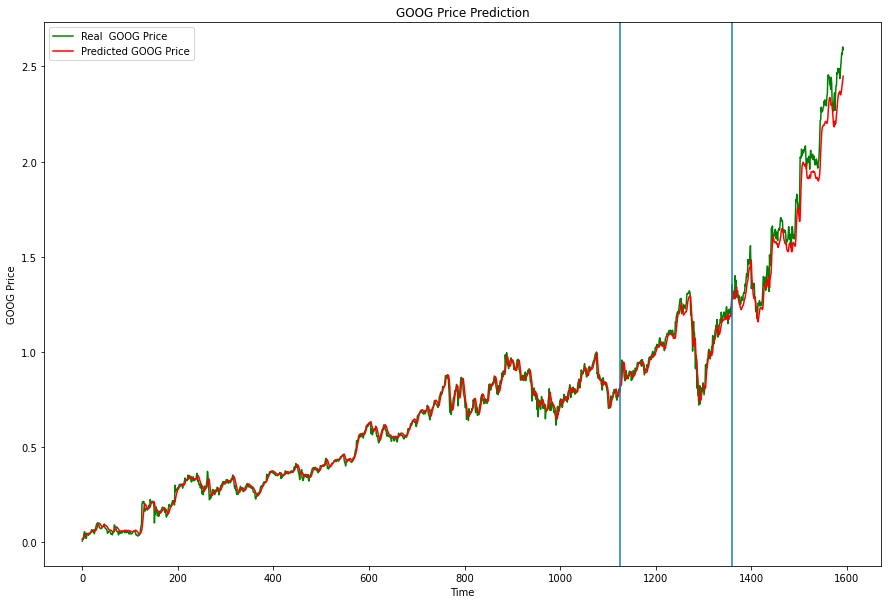

In [ ]:
# Visualising the results
plt.figure(figsize=(15,10))
plt.plot(y_total,color = "green", label = "Real  GOOG Price")
plt.plot(pred, color = "red", label = "Predicted GOOG Price")
plt.title('GOOG Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Price')
plt.axvline(x=train_limit)
plt.axvline(x=val_limit)
plt.legend()
plt.show()

#CNN1D model

We first build the cnn1d model. The global average pooling layer is used to save computations. It has also proven to make some classifiers more robust.

In [ ]:
cnn1d = Sequential()
cnn1d.add(Conv1D(16,3,activation="relu",padding="same",input_shape = (X_train.shape[1], 1)))
cnn1d.add(Conv1D(32,3,activation="relu",padding="same"))
cnn1d.add(Conv1D(64,3,activation="relu",padding="same"))
cnn1d.add(Conv1D(128,3,activation="relu",padding="same"))
cnn1d.add(GlobalAveragePooling1D())
cnn1d.add(Dense(units=1))

The model is fitted to the train set.

In [ ]:
# Compiling the model
cnn1d.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mean_squared_error')

# Fitting the model to the Training set
logs=cnn1d.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs = 1000, batch_size = 128)

Epoch 1/1000
9/9 [==============================] - 28s 58ms/step - loss: 0.3182 - val_loss: 0.9901
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2856 - val_loss: 0.8808
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2444 - val_loss: 0.7665
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2083 - val_loss: 0.6420
Epoch 5/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.1725 - val_loss: 0.5007
Epoch 6/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.1200 - val_loss: 0.3477
Epoch 7/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0704 - val_loss: 0.2022
Epoch 8/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0373 - val_loss: 0.0867
Epoch 9/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0267
Epoch 10/1000
9/9 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0122
Epoch 11/1000
9/9

Again, we evaluate hthe model on the test set.

In [ ]:
cnn1d.evaluate(X_test,y_test)

8/8 [==============================] - 0s 8ms/step - loss: 0.0109


0.010900052264332771

Finally, we build a plot to observe visually the performance of the model. The different set are separated by vertical lines.

In [ ]:
dataset_total=np.concatenate((X_train, X_validation, X_test), axis=0)
pred=cnn1d(dataset_total)
pred=np.squeeze(pred)
y_total=np.concatenate((y_train, y_validation, y_test), axis=0)
train_limit=y_train.shape[0]
val_limit=train_limit+y_validation.shape[0]

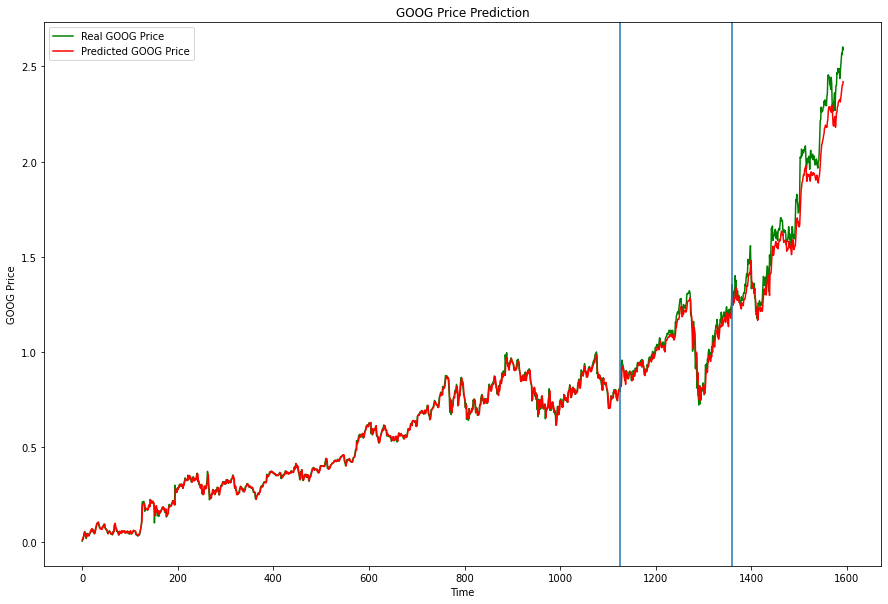

In [ ]:
# Visualising the results
plt.figure(figsize=(15,10))
plt.plot(y_total,color = "green", label = "Real GOOG Price")
plt.plot(pred, color = "red", label = "Predicted GOOG Price")
plt.title('GOOG Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Price')
plt.axvline(x=train_limit)
plt.axvline(x=val_limit)
plt.legend()
plt.show()

#CNN-LSTM model

We first build the cnn model.

In [ ]:
cnn = Sequential()
cnn.add(Conv1D(16,3,activation="relu",padding="same",input_shape = (X_train.shape[1], 1)))
cnn.add(Conv1D(32,3,activation="relu",padding="same"))
cnn.add(Conv1D(64,3,activation="relu",padding="same"))

In [ ]:
cnn.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 10, 16)            64        
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 10, 32)            1568      
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 10, 64)            6208      
Total params: 7,840
Trainable params: 7,840
Non-trainable params: 0
_________________________________________________________________


Then we build the lstm layer that will take the extracted features as inputs.

In [ ]:
lstm = Sequential()
lstm.add(LSTM(units = 50, input_shape = (X_train.shape[1], 64)))
lstm.add(Dense(units = 1))

Finally, we gather both into a bigger model.

In [ ]:
cnn_lstm=Sequential()
cnn_lstm.add(cnn)
cnn_lstm.add(lstm)

... which we fit to the training set.

In [ ]:
# Compiling the model
cnn_lstm.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mean_squared_error')

# Fitting the model to the Training set
logs=cnn_lstm.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs = 1000, batch_size = 128)

Epoch 1/1000
9/9 [==============================] - 2s 74ms/step - loss: 0.3115 - val_loss: 1.0004
Epoch 2/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2768 - val_loss: 0.8816
Epoch 3/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2424 - val_loss: 0.7626
Epoch 4/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.2014 - val_loss: 0.6382
Epoch 5/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1586 - val_loss: 0.5069
Epoch 6/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.1221 - val_loss: 0.3678
Epoch 7/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0827 - val_loss: 0.2298
Epoch 8/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0475 - val_loss: 0.1113
Epoch 9/1000
9/9 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0365
Epoch 10/1000
9/9 [==============================] - 0s 7ms/step - loss: 0.0064 - val_loss: 0.0083
Epoch 11/1000
9/9 

Let's now see how it performs on the test set.

In [ ]:
cnn_lstm.evaluate(X_test,y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.0287


0.02870481088757515

Again, it's always interesting to visually compare the predictions to the true data, so we build and plot this graph.

In [ ]:
dataset_total=np.concatenate((X_train, X_validation, X_test), axis=0)
pred=cnn_lstm(dataset_total)
pred=np.squeeze(pred)
y_total=np.concatenate((y_train, y_validation, y_test), axis=0)
train_limit=y_train.shape[0]
val_limit=train_limit+y_validation.shape[0]

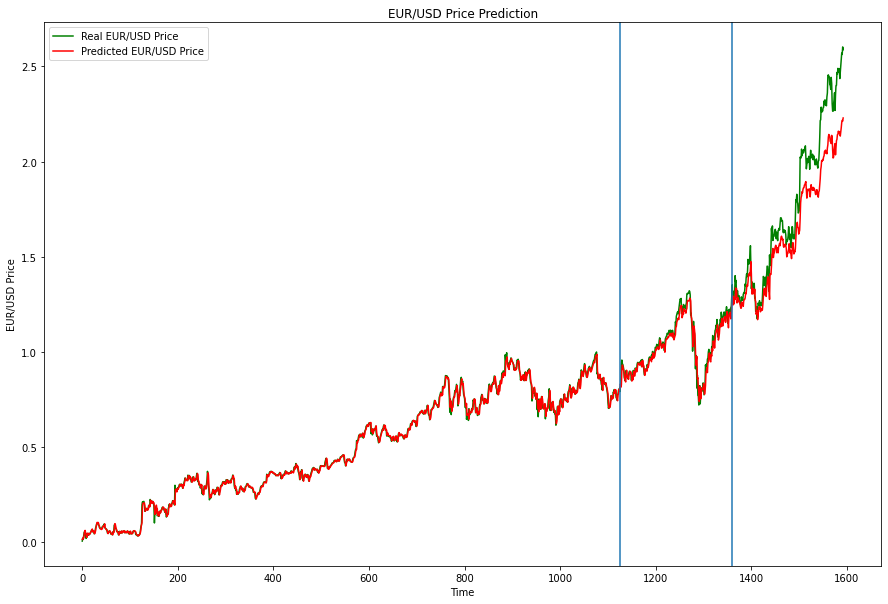

In [ ]:
# Visualising the results
plt.figure(figsize=(15,10))
plt.plot(y_total,color = "green", label = "Real EUR/USD Price")
plt.plot(pred, color = "red", label = "Predicted EUR/USD Price")
plt.title('EUR/USD Price Prediction')
plt.xlabel('Time')
plt.ylabel('EUR/USD Price')
plt.axvline(x=train_limit)
plt.axvline(x=val_limit)
plt.legend()
plt.show()

#Transformer model

Transformers models are relatively recent and there are way more complex than previous architectures because of the self attention mechanism. Therefore, their implementation is a bit trickier. I re used the code from https://www.tensorflow.org/text/tutorials/transformer to avoid having to code everything again from scratch.

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention2(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention2, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask=None):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

def positional(batch_size,seq_len,d_model):
  return tf.repeat(positional_encoding(seq_len,d_model),batch_size,axis=0)

The positional encoding is added to the input data. Note that we do not need to bother with masks in this implementation because the input sequences have a fixed size.

In [ ]:
pos=np.array(positional(X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train=X_train+pos
pos=np.array(positional(X_test.shape[0],X_test.shape[1],X_test.shape[2]))
X_test=X_test+pos
pos=np.array(positional(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2]))
X_validation=X_validation+pos

We build the Transformer model. It uses Mulit Head Attention layers, normalizations with residuals and the feed forward layers were replaced by CNN layers here.

In [ ]:
input=Input(shape=[X_train.shape[1],1])
layer1_1=Conv1D(32,3,activation="relu",padding="same")
layer1_2=Conv1D(128,3,activation="relu",padding="same")
# layer_encoding=Positional_encoding()
layer2_1=MultiHeadAttention2(num_heads=64,d_model=128)
layer2_2=Conv1D(128,3,activation="relu",padding="same")
layer3_1=MultiHeadAttention2(num_heads=64,d_model=128)
layer3_2=Conv1D(128,3,activation="relu",padding="same")
normalization=LayerNormalization()
layer4=GlobalAveragePooling1D()
layer5=Dense(units=1)
output1_1=layer1_1(input)
output1=layer1_2(output1_1)
# output1=layer_encoding(output1)
output2, _ =layer2_1(output1,output1,output1)
output2=normalization(output1+output2)
output3=layer2_2(output2)
output3=normalization(output2+output3)

output4, _ =layer3_1(output3,output3,output3)
output4=normalization(output3+output4)
output5=layer3_2(output4)
output5=normalization(output5+output4)

output=layer5(layer4(output5))
model=Model(input,output)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 10, 32)       128         input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 10, 128)      12416       conv1d_30[0][0]                  
__________________________________________________________________________________________________
tf.compat.v1.shape_4 (TFOpLambd (3,)                 0           conv1d_31[0][0]                  
______________________________________________________________________________________________

This model has way more parameters than the previous ones, so it may require more data to be trained completely.

In [ ]:
# Compiling the RNN
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, validation_data=(X_validation,y_validation), epochs = 1000, batch_size = 128)

Epoch 1/1000
9/9 [==============================] - 5s 160ms/step - loss: 0.3372 - val_loss: 0.0846
Epoch 2/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0352 - val_loss: 0.0597
Epoch 3/1000
9/9 [==============================] - 0s 15ms/step - loss: 0.0281 - val_loss: 0.0101
Epoch 4/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0107 - val_loss: 0.0590
Epoch 5/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0035 - val_loss: 0.0429
Epoch 6/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0026 - val_loss: 0.0236
Epoch 7/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0019 - val_loss: 0.0276
Epoch 8/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0015 - val_loss: 0.0254
Epoch 9/1000
9/9 [==============================] - 0s 14ms/step - loss: 0.0014 - val_loss: 0.0235
Epoch 10/1000
9/9 [==============================] - 0s 13ms/step - loss: 0.0014 - val_loss: 0.0210
Epoch 11

We then evaluate the performance of this model on the test set.

In [ ]:
model.evaluate(X_test,y_test)

8/8 [==============================] - 0s 10ms/step - loss: 0.3389


0.33890777826309204

Finally, we build and visualize the predictions made by the model.

In [ ]:
dataset_total=np.concatenate((X_train, X_validation, X_test), axis=0)
pred=model(dataset_total)
pred=np.squeeze(pred)
y_total=np.concatenate((y_train, y_validation, y_test), axis=0)
train_limit=y_train.shape[0]
val_limit=train_limit+y_validation.shape[0]

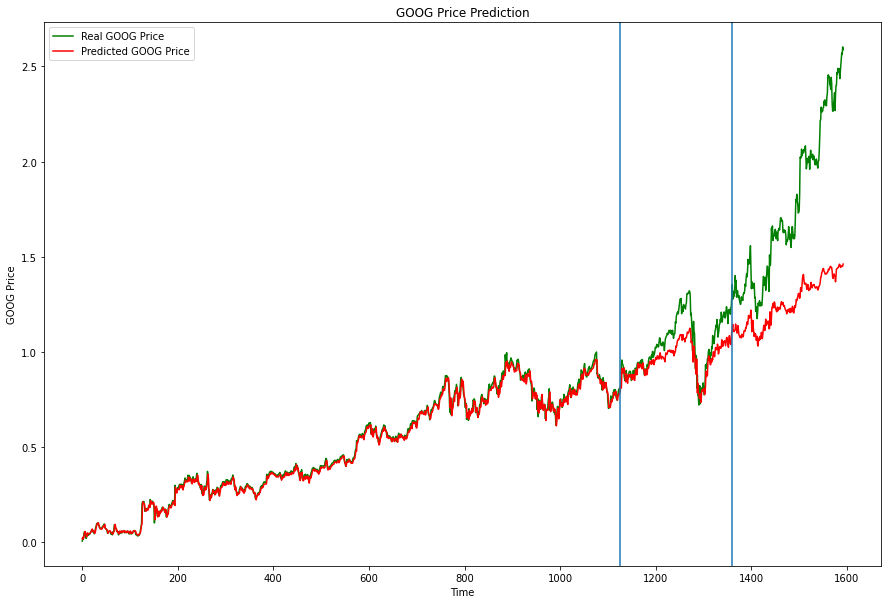

In [ ]:
# Visualising the results
plt.figure(figsize=(15,10))
plt.plot(y_total,color = "green", label = "Real GOOG Price")
plt.plot(pred, color = "red", label = "Predicted GOOG Price")
plt.title('GOOG Price Prediction')
plt.xlabel('Time')
plt.ylabel('GOOG Price')
plt.axvline(x=train_limit)
plt.axvline(x=val_limit)
plt.legend()
plt.show()